# Arm Reacher

---

In this notebook, we're training an a robotic arm to track a moving target (blue-green sphere). 

We use the Unity ML-Agents environment. This is performed as part of a project for the course [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions (README) to double-check that you have installed the necessary packages. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from unityagents import UnityEnvironment

from agent import Agent
from train import train

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next, we will start the environment. **Note that this will only work on a Linux (x64) machine.**

In [2]:
env = UnityEnvironment(file_name="../unity_environment/Reacher.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


You should now see a Unity visualization window just spawned. If you get any pop-ups on the application not responding, just click "Wait" or ignore the message. 

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# Reset the environment.
env_info = env.reset(train_mode=False)[brain_name]

# Number of agents.
num_agents = len(env_info.agents)
print(f'Number of agents: {num_agents}')

# Size of action. 
action_size = brain.vector_action_space_size
print(f'Number of possible actions: {action_size}')

# Size of state. 
states = env_info.vector_observations
state_size = states.shape[1]
print(f'Number of possible states: {state_size}')

Number of agents: 20
Number of possible actions: 4
Number of possible states: 33


### 3. Take Random Actions in the Environment

Let's confirm that we have everything set up and the visualization works. 

Here, we will watch the agents' (robot arms) performance, as they select actions (uniformly) at random with each time step.  A window should pop up that allows you to observe the agents, as they move through the environment.  

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.06199999861419201


### 4. Let's train the arm!

Let's construct our robotic arm from the `Agent` class. 

In [6]:
arm = Agent(state_size=state_size, action_size=action_size, device=device, seed=0)

Let's begin training. 

In [7]:
NUM_EPISODES = 300                  # Maximum number of training episodes.
MAX_TIME_IN_EPISODE = 1000          # Maximum number of timesteps per episode.
SCORE_ACCEPTANCE_THRESHOLD = 30.    # The average score of all agents for the task to be considered successful. 

In [8]:
scores, num_episodes_to_acceptance_threshold = train(env, 
                                                     brain_name, 
                                                     arm, 
                                                     NUM_EPISODES, 
                                                     MAX_TIME_IN_EPISODE, 
                                                     SCORE_ACCEPTANCE_THRESHOLD)

if num_episodes_to_acceptance_threshold is not None: 
    print(f"\nOur arm learnt to get a score of {SCORE_ACCEPTANCE_THRESHOLD} \
          in {num_episodes_to_acceptance_threshold} episodes.")

Episode 100	Average Score (over 100 consecutive episodes): 8.94
Episode 200	Average Score (over 100 consecutive episodes): 30.14
Episode 300	Average Score (over 100 consecutive episodes): 34.86

Our arm learnt to get a score of 30.0           in 99 episodes.


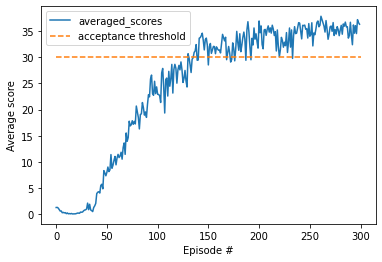

In [9]:
# Plot the scores over learning time. 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='averaged_scores')
plt.plot([0, len(scores)], [SCORE_ACCEPTANCE_THRESHOLD, SCORE_ACCEPTANCE_THRESHOLD], 
         linestyle='dashed', 
         label='acceptance threshold')
plt.ylabel('Average score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

Save the parameters of the Q network. 

In [10]:
torch.save(arm.actor_local.state_dict(), '../model/trained_actor.pt')
torch.save(arm.critic_local.state_dict(), '../model/trained_critic.pt')

### 5. Test our arm's performance. 

In [11]:
# Load the weights from file. 
arm.actor_local.load_state_dict(torch.load('../model/trained_actor.pt'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = arm.act(states)                          # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print(f'Total score (averaged over agents) this episode: {round(np.mean(scores),3)}')

Total score (averaged over agents) this episode: 38.508


In [12]:
env.close()